# DIABLO 
### (Data Integration Analysis for Biomarker discovery using Latent cOmponents) 

Code adapted from [mixOmics](http://mixomics.org/mixdiablo/diablo-tcga-case-study/) documentation.

**How does DIABLO work?**
DIABLO is an extension of the PLS-DA method, adapted for multi-block data integration, which means it can handle multiple dataset simultaneously. 
The primary goal of DIABLO is to identify a subset of features from each dataset that are not only discriminative of the conditions or classes in the study but are also correlated across the different datasets.

 DIABLO integrates data from different sources (blocks) by finding latent components that are correlated across these blocks while still being able to discriminate between conditions or classes in the data.
 Like sPLS-DA, DIABLO uses sparsity to select a limited number of features in each block, which contributes to the model. This is achieved using L1-penalization, which forces some loadings to shrink to zero.
 
**In this notebook, we will:**
Create a DIABLO model for binary classification (Decliners vs Stable) using the metabolomics, lipidomics, and proteomics datasets. This will include:
- Creating the design matrix to specify the relationships between the datasets
- Tuning the number of components to be used
- Tuning the number of features to be selected
- Building the final DIABLO model
- Evaluating the model performance

In [1]:
import os
# Set the environment variables
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.4.0"
os.environ["PATH"]   = r"C:\Program Files\R\R-4.4.0\bin\x64" + ";" + os.environ["PATH"]

In [2]:
from methods.helper import *
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\mjgoj\miniconda3\Lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


None
     RID  ThreeClass  TwoClass   AVLTIDEK  LSITGTYDLK  SVLGQLGITK  \
0      4           1         0  11.015458    4.920400   13.204807   
1      8           1         0   9.869124    4.885254   14.089945   
2     14           0         0   8.319413    5.179828   13.012452   
3     19           0         0   9.915598    5.279434   13.599989   
4     23           1         0  10.179433    4.812406   13.565679   
..   ...         ...       ...        ...         ...         ...   
91  1130           1         1   9.972025    4.991170   13.348450   
92  1260           1         1   8.392018    4.765898   13.556793   
93  1295           2         1  10.095396    5.078808   13.798429   
94  1393           2         1  10.456226    5.164861   13.638487   
95  1394           2         1  10.107979    5.045091   13.081318   

    NGVAQEPVHLDSPAIK  SGLSTGWTQLSK  DLLLPQPDLR  VAAGAFQGLR  ...  TLSDYNIQK  \
0          18.080988     23.295382   34.783867   30.776336  ...  36.523943   
1         

In [3]:
%load_ext rpy2.ipython

Loading the three omics datasets and splitting it into predefined train / test split (60 -40)

In [32]:
# Load data
lipidomics, metabolomics, proteomics = load_data()

In [33]:
# Get the train - test split
lipidomics_train, lipidomics_test = get_train_test_split_dataset(lipidomics)
metabolomics_train, metabolomics_test = get_train_test_split_dataset(metabolomics)
proteomics_train, proteomics_test = get_train_test_split_dataset(proteomics)
    
Y_train, Y_test = metabolomics_train["TwoClass"], metabolomics_test["TwoClass"]
Y_train, Y_test = Y_train.astype('int'), Y_test.astype('int')

In [34]:
# Remove the class column from the datasets and leave only features
lipidomics_train = lipidomics_train.drop(columns=["TwoClass", "RID", "ThreeClass"])
lipidomics_test = lipidomics_test.drop(columns=["TwoClass", "RID", "ThreeClass"])
metabolomics_train = metabolomics_train.drop(columns=["TwoClass", "RID", "ThreeClass"])
metabolomics_test = metabolomics_test.drop(columns=["TwoClass", "RID", "ThreeClass"])
proteomics_train = proteomics_train.drop(columns=["TwoClass", "RID", "ThreeClass"])
proteomics_test = proteomics_test.drop(columns=["TwoClass", "RID", "ThreeClass"])

Changing the format of the input data to match MixOmics package specifications,
Since a DIABLO model is only implemented in R language, I will use the R cells within the notebook

In [35]:
%%R -i lipidomics_train -i lipidomics_test -i metabolomics_train -i metabolomics_test -i proteomics_train -i proteomics_test -i Y_train -i Y_test
# Passing the data to the R cell

# Read the required libraries
library(readxl) 
library(mixOmics)
library(reshape2)

# Get the data in a format required by the MixOmics models
X.train <- list(
  Metabolomics = metabolomics_train,
  Lipidomics = lipidomics_train,
  Proteomics = proteomics_train
)

X.test <- list(
  Metabolomics = metabolomics_test,
  Lipidomics = lipidomics_test,
  Proteomics = proteomics_test
)

# Double checking the size of the dataset
sapply(X.train, nrow)

Metabolomics   Lipidomics   Proteomics 
          58           58           58 


### Determining Correlation between the datasets

Generating the **pairwise PLS comparisons** with one omics datasets. I will plot the correlation between the top n features of omics data type.

In [36]:
%%R
n <- 40  # How many variables to select in each data set
list.keepX <- c(n, n)
list.keepY <- c(n, n)

# generate three pairwise PLS models
pls1 <- spls(
    metabolomics_train, lipidomics_train, 
    keepX = list.keepX, keepY = list.keepY)
    
pls2 <- spls(
    metabolomics_train, proteomics_train, 
    keepX = list.keepX, keepY = list.keepY)
    
pls3 <- spls(
    lipidomics_train, proteomics_train, 
    keepX = list.keepX, keepY = list.keepY)

In [37]:
%%R
CUTOFF = 0.4 # Significance cutoff
color_map <- c('darkorchid', 'lightgreen', 'coral')

          comp1        comp2
comp1 0.9302222 7.267450e-17
comp2 0.0595647 8.730815e-01
Correlation of metabolomics and lipidomics datasets:  0.9302222

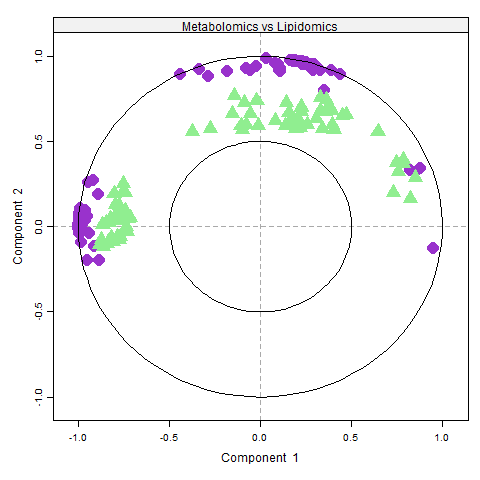

In [38]:
%%R
# Creating the Circle Correlation Plots
# Set the size of the plot
options(repr.plot.width=35, repr.plot.height=10)
plotVar(
    pls1, cutoff = CUTOFF, title = "Metabolomics vs Lipidomics", 
    col = color_map[1:2], style='lattice',
    var.names = FALSE, pch = c(16, 17), cex = c(2,2))
    
print(cor(pls1$variates$X, pls1$variates$Y))
relation_met_lip <- cor(pls1$variates$X, pls1$variates$Y)[1, 1]
cat("Correlation of metabolomics and lipidomics datasets: ", relation_met_lip)

           comp1        comp2
comp1 0.50601622 3.465046e-17
comp2 0.04333592 5.230141e-01
Correlation of metabolomics and proteomics datasets:  0.5060162

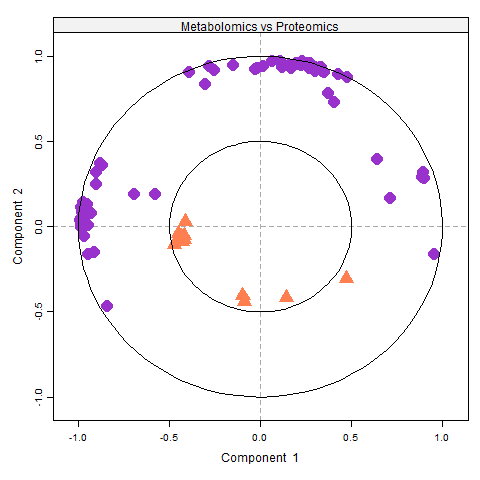

In [39]:
%%R
plotVar(
    pls2, cutoff = CUTOFF, title = "Metabolomics vs Proteomics", 
    col = c(color_map[1], color_map[3]), style='lattice',
    var.names = FALSE, pch = c(16, 17), cex = c(2,2))
    
print(cor(pls2$variates$X, pls2$variates$Y))
relation_met_prot <- cor(pls2$variates$X, pls2$variates$Y)[1, 1]
cat("Correlation of metabolomics and proteomics datasets: ", relation_met_prot)

           comp1         comp2
comp1  0.6356547 -2.460562e-16
comp2 -0.3632144  6.110303e-01
Correlation of lipidomics and proteomics datasets:  0.6356547

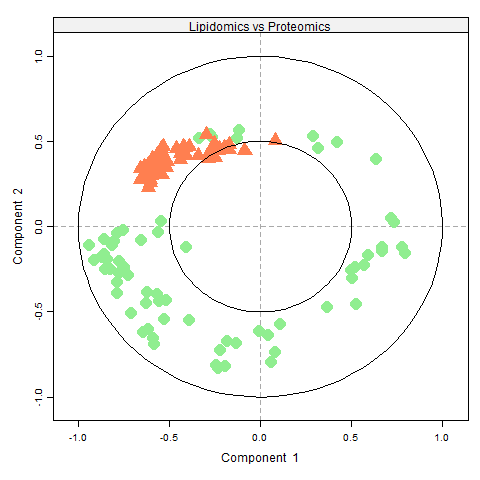

In [40]:
%%R
plotVar(
    pls3, cutoff = CUTOFF, title = "Lipidomics vs Proteomics", 
    col = color_map[2:3], style='lattice',
    var.names = FALSE, pch = c(16, 17), cex = c(2,2))
print(cor(pls3$variates$X, pls3$variates$Y))
relation_lip_prot <- cor(pls3$variates$X, pls3$variates$Y)[1, 1]
cat("Correlation of lipidomics and proteomics datasets: ", relation_lip_prot)

### Creating the Design Matrix

As written in the MixOMics documentation _Design_ refers to the relationship structure between the various inputted dataframes. In this matrix each value (between 0-1) represents the strength of the relationship to be modeled between two given omics types.

In [41]:
%%R
names <- c("Metabolomics", "Lipidomics", "Proteomics")
design = matrix(
  0, ncol=3, nrow=3, 
  dimnames = list(names, names)
)
diag(design) = 0 # set diagonal to 0s

# Add the specific relationship strength
design["Metabolomics", "Lipidomics"] = relation_met_lip
design["Lipidomics", "Metabolomics"] = relation_met_lip
design["Metabolomics", "Proteomics"] = relation_met_prot
design["Proteomics", "Metabolomics"] = relation_met_prot
design["Lipidomics", "Proteomics"] = relation_lip_prot
design["Proteomics", "Lipidomics"] = relation_lip_prot

print(design)

             Metabolomics Lipidomics Proteomics
Metabolomics    0.0000000  0.9302222  0.5060162
Lipidomics      0.9302222  0.0000000  0.6356547
Proteomics      0.5060162  0.6356547  0.0000000


### Creating a Preliminary DIABLO Model

In [42]:
%%R
basic.diablo.model = block.splsda(
  X=X.train, Y=Y_train, ncomp=8, design=design
) 

R[write to console]: Design matrix has changed to include Y; each block will be
            linked to Y.



### Tuning the number of components

In [43]:
%%R
# When this flag is set to be true then the tuning of number of components and features in each block will be tuned. This might take a while, so please be patient
# Otherwise, hyperparameters that were found to be the most optimal in the previous tuning procedure will be chosen. This is done to save time.
TUNING = FALSE

In [44]:
%%R
if (TUNING == TRUE) {
  # Tune the number of components
  perf.diablo = perf(
    basic.diablo.model, validation = 'Mfold', progressBar = FALSE,
    dist='all', folds = 5, nrepeat = 20) 
    
    # Plot the output of tuning
    plot(perf.diablo, col = color.mixo(4:6)) 
    
    print(perf.diablo$choice.ncomp$WeightedVote)

    # Get the number of components according to BER and Mahalanobis distance
    ncomp <- perf.diablo$choice.ncomp$WeightedVote[2,3]
    print(ncomp)
}

In [51]:
%%R
# We can specify additionally if other distance metric or number of components 
# will be used for further tuning
dist <- "mahalanobis.dist"
ncomp <- 4

### Tuning the number of features

On the contrary to the sPLS-DA model feature selection is conducted for each dataset separately.
We are specifically interested in **BER** (Balanced Error Rate), which uses class proportions to weight each classes.


In [52]:
%%R

# Determine the percentage of features to keep
from <- 0.01
to <- 0.9
step <- 0.1

test.keepX = list(
  Metabolomics = seq(
    as.integer(from * ncol(X.train$Metabolomics)), 
    as.integer(to * ncol(X.train$Metabolomics)), 
    as.integer(step * ncol(X.train$Metabolomics))
  ),
  Lipidomics = seq(
    as.integer(from * ncol(X.train$Lipidomics)), 
    as.integer(to * ncol(X.train$Lipidomics)), 
    as.integer(step * ncol(X.train$Lipidomics))
  ),
  Proteomics = seq(
    as.integer(from * ncol(X.train$Proteomics)),
    as.integer(to * ncol(X.train$Proteomics)),
    as.integer(step * ncol(X.train$Proteomics))
  )
)
# Those are the values that will be tested
print(test.keepX)

$Metabolomics
 [1]   2  23  44  65  86 107 128 149 170 191

$Lipidomics
 [1]   5  62 119 176 233 290 347 404 461 518

$Proteomics
[1]   3  35  67  99 131 163 195 227 259


In [53]:
%%R
if (TUNING == TRUE) {
  # Tune the nnumber of features to keep for each omics block
  tune.diablo = tune.block.splsda(
    X = X.train, Y = Y_train, 
    ncomp = ncomp, test.keepX = test.keepX, 
    design = design, validation = 'Mfold', 
    folds = 5, nrepeat = 3, dist = dist, progressBar = TRUE)
    
    list.keepX <- tune.diablo$choice.keepX
  }

In [54]:
%%R
# This is the final list of the number of features to keep fo each block
print(list.keepX)

$Lipidomics
[1] 347   5   5   5

$Metabolomics
[1]  44  23 191  86

$Proteomics
[1]  35 131  99 163


# Final DIABLO Model
In the final DIABLO model we will used the tuned hyperparameters
- number of features to keep for each omics block
- number of components

In [55]:
%%R
if (TUNING == FALSE) {
    ncomp <- 4
    # Keep x for each data type
    lipidomics_keepX <- c(347, 5, 5, 5)
    metabolomics_keepX <- c(44, 23, 191, 86)
    proteomics_keepX <- c(35, 131, 99, 163)
    
    list.keepX <- list(
      Lipidomics = lipidomics_keepX,
      Metabolomics = metabolomics_keepX,
      Proteomics = proteomics_keepX
    )
}
final.diablo.model = block.splsda(
   X=X.train, Y=Y_train, 
   design=design, ncomp = ncomp, keepX = list.keepX
)

R[write to console]: Design matrix has changed to include Y; each block will be
            linked to Y.



**Diablo Plot**

I will plot here results for the first DIABLO components as it typically captures the highest variance/correlation that separates classes across the datasets, while subsequent components may capture additional, sometimes subtler, patterns.

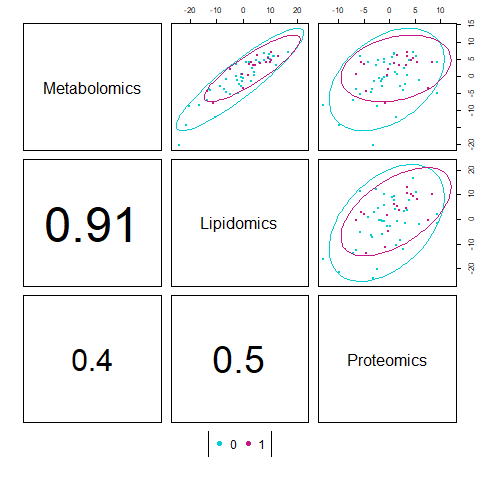

In [56]:
%%R
color_map <- c('darkturquoise', 'mediumvioletred')
plotDiablo(final.diablo.model, ncomp = 1, legend = TRUE, col = color_map)

### Evaluation of the Performance of the Model

In [57]:
%%R
predict.diablo = predict(final.diablo.model, newdata = X.test)
# For each component, we predict the test set
y_pred <- predict.diablo$WeightedVote$mahalanobis.dist[,ncomp]
print(y_pred)

  0   1   2   4   6   9  10  11  14  15  16  18  19  22  25  30  33  34  35  37 
"0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "1" "0" "0" "0" "1" "0" "0" "0" "0" "0" 
 38  39  43  49  53  62  64  67  68  69  73  75  76  78  79  80  83  89 
"1" "1" "0" "0" "0" "0" "0" "0" "1" "1" "0" "1" "0" "0" "0" "0" "1" "1" 


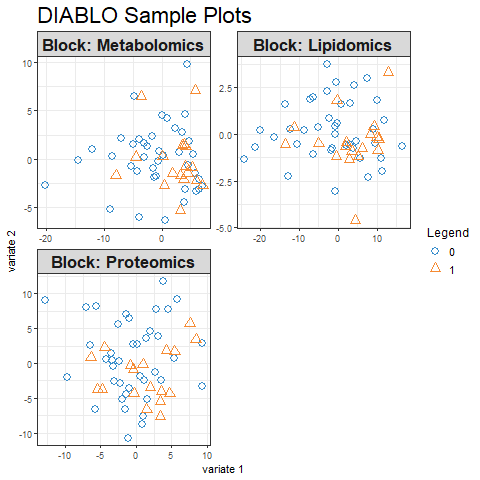

In [58]:
%%R
plotIndiv(final.diablo.model, ind.names = FALSE, legend = TRUE, 
 title = 'DIABLO Sample Plots')

Accuracy of the model: 0.7632
Recall of the model: 0.7632
Precision of the model: 0.7726
Weighted F1 score of the model: 0.7673
Matthews Correlation Coefficient of the model: 0.3699


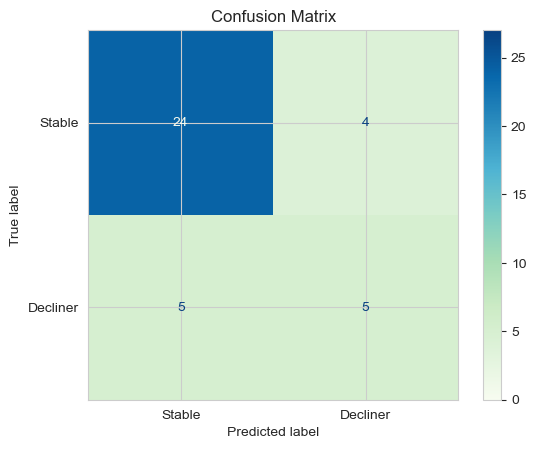

In [59]:
# Back to python!
# Final evaluation of the model
y_pred = %R y_pred
# Cast the predictions to integer
y_pred = y_pred.astype(int)
evaluate_model(Y_test, y_pred)
plot_confusion_matrix(Y_test, y_pred, 27)

### Loading Plots
Loadings are vectors with the weight of each original variable's contribution to the corresponding latent component. Here, we visualize the importance for selected features for each component.

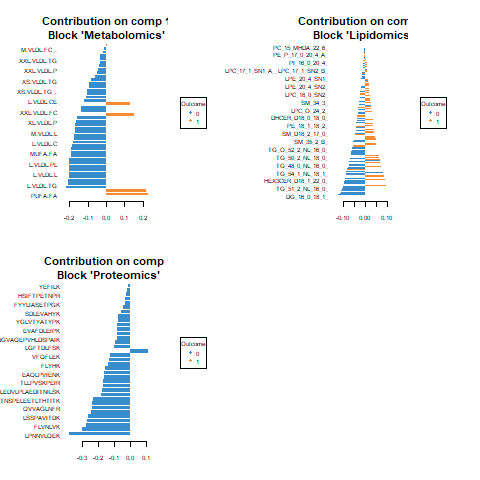

In [26]:
%%R
# Feature Importance for the 1sst component
plotLoadings(final.diablo.model, comp = 1, contrib = 'max', method = 'median')

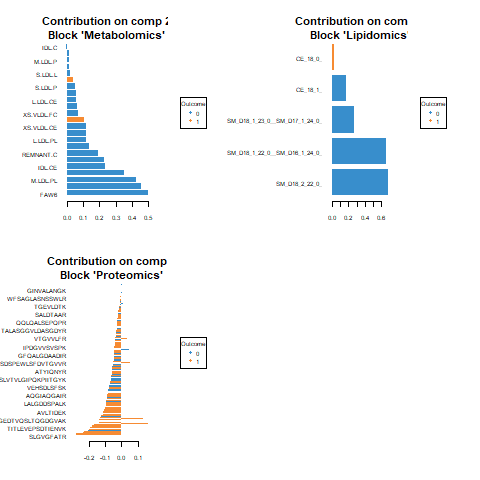

In [27]:
%%R
# Feature Importance for the 2nd component
plotLoadings(final.diablo.model, comp = 2, contrib = 'max', method = 'median')

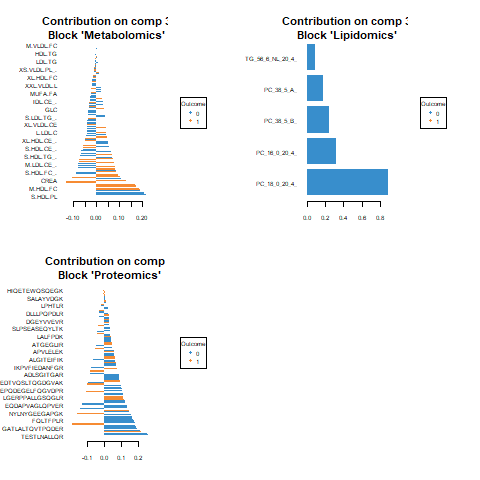

In [28]:
%%R
# Feature Importance for the 3rd component
plotLoadings(final.diablo.model, comp = 3, contrib = 'max', method = 'median')

### Diablo Arrow Plot
This plot shows the agreement between all data sets at the sample level. The start of the arrow indicates the centroid between all data sets for a given sample and the tips of the arrows indicate the location of that sample in each block.

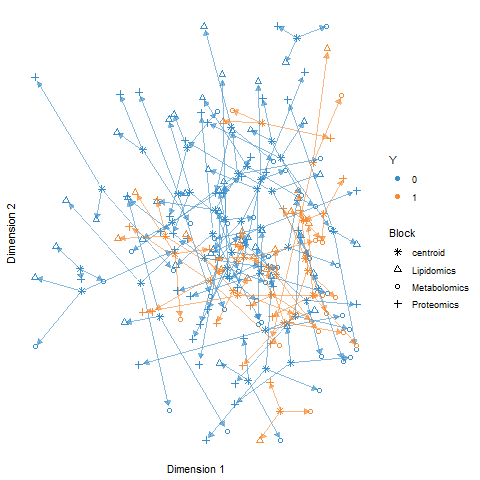

In [29]:
%%R
plotArrow(
    final.diablo.model, ind.names = FALSE, 
    legend = TRUE, title = 'DIABLO Arrow Plot', col = color_map)

Now I will save the features selected by the DIABLO model to a csv file

In [30]:
%%R
# Save the features selected by the DIABLO model

results <- data.frame()


for (i in 1:ncomp) {
  # Get the selected features for each component i
  selected_metabolites <- selectVar(final.diablo.model, block='Metabolomics', comp=i)$Metabolomics
  selected_lipids <- selectVar(final.diablo.model, block='Lipidomics', comp=i)$Lipidomics
  selected_proteins <- selectVar(final.diablo.model, block='Proteomics', comp=i)$Proteomics
  
  metabolites_feature_names <- rownames(selected_metabolites$value)
  metabolites_feature_values <- selected_metabolites$value
  metabolites_block <- rep("Metabolomics", length(metabolites_feature_names))
  metabolites_comp <- rep(i, length(metabolites_feature_names))
  
  lipids_feature_names <- rownames(selected_lipids$value)
  lipids_feature_values <- selected_lipids$value
  lipids_block <- rep("Lipidomics", length(lipids_feature_names))
  lipids_comp <- rep(i, length(lipids_feature_names))
  
  proteins_feature_names <- rownames(selected_proteins$value)
  proteins_feature_values <- selected_proteins$value
  proteins_block <- rep("Proteomics", length(proteins_feature_names))
  proteins_comp <- rep(i, length(proteins_feature_names))
  
  # Create data frames for each block
  metabolites_df <- data.frame(
    Feature = metabolites_feature_names, 
    Value = metabolites_feature_values, 
    Block = metabolites_block, 
    Component = metabolites_comp)
    
  lipids_df <- data.frame(
    Feature = lipids_feature_names, 
    Value = lipids_feature_values, 
    Block = lipids_block, 
    Component = lipids_comp)
    
  proteins_df <- data.frame(
    Feature = proteins_feature_names, 
    Value = proteins_feature_values, 
    Block = proteins_block, 
    Component = proteins_comp)
  
  result <- rbind(metabolites_df, lipids_df, proteins_df)
  # Append to the main results data frame
  results <- rbind(results, result)
}

# Rename the columns
colnames(results) <- c("Feature", "Coefficient", "Block", "Component")
head(results)

            Feature Coefficient        Block Component
PUFA.FA     PUFA.FA   0.2300838 Metabolomics         1
FAW6.FA     FAW6.FA   0.2174727 Metabolomics         1
VLDL.D       VLDL.D  -0.2163167 Metabolomics         1
L.VLDL.TG L.VLDL.TG  -0.2051405 Metabolomics         1
VLDL.TG     VLDL.TG  -0.2049874 Metabolomics         1
L.VLDL.P   L.VLDL.P  -0.2016867 Metabolomics         1


In [31]:
%%R
# Save the results to a csv file
RESULTS_PATH <- "C:/Users/mjgoj/PycharmProjects/ThesisFinal/results/"
write.csv(results, paste0(RESULTS_PATH, "diablo_features.csv"), row.names=FALSE)